In [1]:
%pylab inline

#from mpl_toolkits.mplot3d import Axes3D
import os
import scipy.constants as cst
from lammpsrun import LAMMPS, Prism
from PBSJobSubmissionScript import PBS_Submitter

from ase import Atoms, units
from ase.visualize import view
from ase.io.trajectory import Trajectory
from ase.io import write, read
from ase.build import surface
from ase.spacegroup import crystal

cx1_out = r"/rds/general/user/yx6015/home/cx1_out/"
sim_path = r"/rds/general/user/yx6015/home/LAMMPS_Simulation/"
print(cx1_out + '\n' + sim_path)

Populating the interactive namespace from numpy and matplotlib
/rds/general/user/yx6015/home/cx1_out/
/rds/general/user/yx6015/home/LAMMPS_Simulation/


# Optimizing thickness for siderite slabs

In [2]:
siderite = crystal(symbols = ['Fe', 'C', 'O'],
                    basis = [(0, 0, 0), 
                             (0, 0, 0.25),
                             (0.2748, 0, 0.25)],
                    spacegroup=167,
                    cellpar=[4.72, 4.72, 15.51, 90, 90, 120])

In [52]:
# Atoms C Fe O
siderite_bulk_reaxff_params = {
    # Initialization
    "units": "real",
    "atom_style": "charge",
    "mass": ["1 12.011",
             "2 55.845",
             "3 15.999"],
    
    # Forcefield definition
    "pair_style": "reax/c NULL safezone 16",
    "pair_coeff": ['* * ' + 'ffield.reax.Fe_O_C_H_combined' + ' C Fe O'],
    "neighbor": "2.0 bin",
    "neighbor_modify": "delay 10 check yes",
    
    # Run and Minimization
    "minimize": ["1e-25 1e-25 10000 10000"],
    "min_style": "cg",
    "timestep": 0.1,
    "fix": ["1 all box/relax iso 0.0 vmax 0.001",
            "2 all qeq/reax 1 0.0 10.0 1e-6 reax/c"]
}

# Atoms C Fe O
siderite_slab_reaxff_params = {
    # Initialization
    "units": "real",
    "atom_style": "charge",
    "mass": ["1 12.011",
             "2 55.845",
             "3 15.999"],
    
    # Forcefield definition
    "pair_style": "reax/c NULL safezone 16",
    "pair_coeff": ['* * ' + 'ffield.reax.Fe_O_C_H_combined' + ' C Fe O'],
    #"neighbor": "2.0 bin",
    #"neighbor_modify": "delay 10 check yes",
    
    # Run and Minimization
    "minimize": ["1e-25 1e-25 10000 10000"]*5,
    "min_style": "sd",
    "min_modify": "line quadratic",
    "timestep": 0.5,
    "fix": ["1 all box/relax x 0.0 y 0.0 xy 0.0 vmax 0.001 nreset 128",
            "2 all qeq/reax 1 0.0 10.0 1e-6 reax/c"]
}

## Thickness Convergence Test

Using the following equation and form:

$$
E_s = \frac{E^n_{slab} - n(E^n_{slab} - E^{n-1}_{slab})}{2A}
$$

While the thickness of slab reaches an adequate value, where the central atom positions are fixed,
$(E^n_{slab} - E^{n-1}_{slab})$ should converge to $𝐸_{bulk}$

In [53]:
siderite_thickness = arange(1, 11)
siderite_thickness_input = ["siderite_opt104_l{0}_reaxff_minimize.in".format(x) for x in siderite_thickness]
siderite_thickness_commands = ["mpiexec lmp_mpi -in {0} -screen none\n".format(x) for x in siderite_thickness_input]
siderite_thickness_names = ["siderite_opt104_l{0}".format(x) for x in siderite_thickness]
siderite_thickness_calc = LAMMPS(parameters = siderite_slab_reaxff_params,
                                 no_data_file=True, always_triclinic=True)

In [57]:
for s_thickness, s_input in zip(siderite_thickness, siderite_thickness_input):
    sCurrentThickness = surface(siderite, (1, 0, 4), s_thickness, vacuum=10)
    sCurrentThickness = sCurrentThickness.repeat((2, 2, 1))
    #sCurrentThickness.rattle(stdev=0.05, seed = 101)
        
    sCurrentThickness.set_calculator(siderite_thickness_calc)
    siderite_thickness_calc.atoms = sCurrentThickness.copy()
    siderite_thickness_calc.prism = Prism(siderite_thickness_calc.atoms.get_cell())
    
    siderite_thickness_calc.write_lammps_in(lammps_in = sim_path + "siderite/opt/" + s_input)

In [58]:
sid_thickness_PBS = PBS_Submitter(job_names=siderite_thickness_names,
                                  job_commands=siderite_thickness_commands,
                                  modules=["mpi", "lammps", "intel-suite/2017.6"],
                                  walltime="4:00:00",
                                  proc_cpus=8,
                                  proc_mpiprocs=8,
                                  memory=4)
#sid_thickness_PBS.params

In [59]:
curr_dir = os.getcwd()
os.chdir(sim_path + "siderite/opt")

sid_thickness_out, sid_thickness_err = sid_thickness_PBS.run()

os.chdir(curr_dir)

In [43]:
sid_thickness_out

['2130428.cx1',
 '2130429.cx1',
 '2130430.cx1',
 '2130431.cx1',
 '2130432.cx1',
 '2130433.cx1',
 '2130434.cx1',
 '2130435.cx1',
 '2130436.cx1',
 '2130437.cx1']

In [49]:
# Move all the log and error files over
for sid_thickness_logfile, sid_thickness_job_fd in zip(siderite_thickness_names, sid_thickness_out):
    !mv {sim_path}siderite/opt/{sid_thickness_logfile}.* {cx1_out}{sid_thickness_job_fd}/

In [50]:
# Reading log file
opt_pe = []
opt_no = []
for s_file, s_surface in zip(sid_thickness_out, siderite_thickness):
    siderite_thickness_calc.read_lammps_log(lammps_log = cx1_out + s_file + '/log.lammps')
    siderite_opt_data = siderite_thickness_calc.thermo_content[-1]
    
    opt_pe.append(siderite_opt_data['pe'])
    opt_no.append(siderite_opt_data['atoms'])

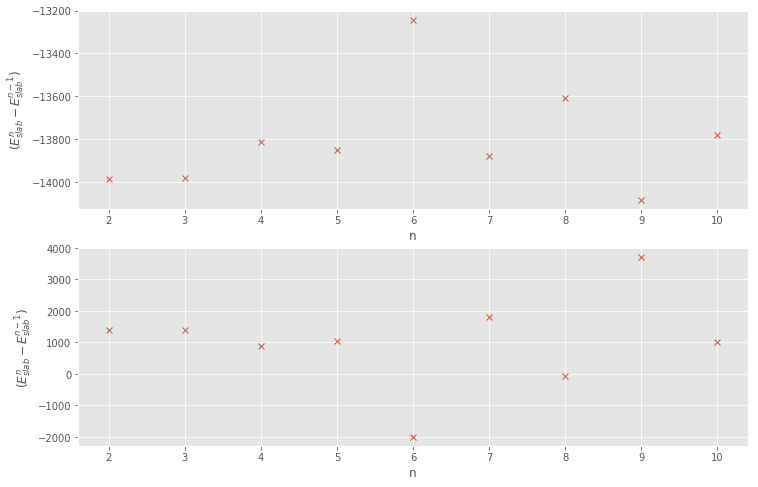

In [51]:
opt_pe_arr = array(opt_pe)
se_arr = opt_pe_arr[1:] - array(siderite_thickness[1:]) * (opt_pe_arr[1:] - opt_pe_arr[:-1])

style.use('ggplot')
figure(figsize=(12, 8))

subplot(2, 1, 1)
plot(siderite_thickness[1:], opt_pe_arr[1:] - opt_pe_arr[:-1], ' x')
xlabel("n")
ylabel("$(E^n_{slab} - E^{n-1}_{slab})$")

subplot(2, 1, 2)
plot(siderite_thickness[1:23], se_arr[:22], ' x')
xlabel("n")
ylabel("$(E^n_{slab} - E^{n-1}_{slab})$")

show()

Crystallographic data is obtained from https://materials.springer.com/isp/crystallographic/docs/sd_1628167

# Bulk siderite crystal

In [4]:
# Increasing size to improve QEq accuracy (>1 nm)
siderite_bulk = siderite.repeat((3, 3, 1))
siderite_bulk.center()

In [5]:
# Setting up simulation input
siderite_bulk_calc = LAMMPS(parameters = siderite_bulk_reaxff_params,
                            no_data_file=True)

siderite_bulk.set_calculator(siderite_bulk_calc)
siderite_bulk_calc.atoms = siderite_bulk.copy()
siderite_bulk_calc.prism = Prism(siderite_bulk_calc.atoms.get_cell())

In [6]:
# Writing input file
siderite_bulk_calc.write_lammps_in(lammps_in = sim_path + "siderite/siderite_bulk_reaxff_minimize.in",
                                   lammps_trj = "siderite_bulk_reaxff_minimize.lammpstrj")

In [7]:
sid_bulk_PBS = PBS_Submitter(job_names="siderite_reaxff_minimize",
                             job_commands="mpiexec lmp_mpi -in siderite_bulk_reaxff_minimize.in -screen none",
                             modules=["mpi", "lammps", "intel-suite/2017.6"],
                             walltime="4:00:00",
                             proc_cpus=4,
                             proc_mpiprocs=4,
                             memory=4)
sid_bulk_PBS.params

{'job_commands': ['mpiexec lmp_mpi -in siderite_bulk_reaxff_minimize.in -screen none'],
 'job_names': ['siderite_reaxff_minimize'],
 'memory': [4],
 'modules': [['mpi', 'lammps', 'intel-suite/2017.6']],
 'proc_cpus': [4],
 'proc_mpiprocs': [4],
 'proc_nodes': [1],
 'walltime': ['4:00:00']}

In [8]:
curr_dir = os.getcwd()
os.chdir(sim_path + "siderite")

sid_bulk_out, sid_bulk_err = sid_bulk_PBS.run()

os.chdir(curr_dir)

Submitted Job: siderite_reaxff_minimize
b'2123473.cx1\n' b''


In [15]:
siderite_bulk_calc.read_lammps_log(lammps_log = cx1_out + sid_bulk_out[0] + '/log.lammps')
siderite_bulk_data = siderite_bulk_calc.thermo_content[-1]

pe_bulk = siderite_bulk_data['pe']/siderite_bulk_data['atoms']

# Surfaces/Slabs

Past work done with surface 104, 110, 100, 101, 001 and 012. High surface energy on 100 and 101

In [9]:
siderite_surfaces = ['104', '110', '100', '101', '001', '012']
siderite_surfaces_input = ["siderite_slab{0}_reaxff_minimize.in".format(x) for x in siderite_surfaces]
siderite_surfaces_commands = ["mpiexec lmp_mpi -in {0} -screen none\n".format(x) for x in siderite_surfaces_input]
siderite_surfaces_names = ["siderite{0}_reaxff_min".format(x) for x in siderite_surfaces]

for s_surface, s_input in zip(siderite_surfaces, siderite_surfaces_input):
    sCurrentSurface = surface(siderite, (int(s_surface[0]), int(s_surface[1]), int(s_surface[2])), 24, vacuum=10)
    sCurrentSurface = sCurrentSurface.repeat((2, 2, 1))
    
    sCurrentSurface_calc = LAMMPS(parameters = siderite_slab_reaxff_params,
                                  no_data_file=True, always_triclinic=True)
    
    sCurrentSurface.set_calculator(sCurrentSurface_calc)
    sCurrentSurface_calc.atoms = sCurrentSurface.copy()
    sCurrentSurface_calc.prism = Prism(sCurrentSurface_calc.atoms.get_cell())
    
    sCurrentSurface_calc.write_lammps_in(lammps_in = sim_path + "siderite/" + s_input)

In [10]:
sid_surfaces_PBS = PBS_Submitter(job_names=siderite_surfaces_names,
                                 job_commands=siderite_surfaces_commands,
                                 modules=["mpi", "lammps", "intel-suite/2017.6"],
                                 walltime="4:00:00",
                                 proc_cpus=4,
                                 proc_mpiprocs=4,
                                 memory=4)
sid_surfaces_PBS.params

{'job_commands': ['mpiexec lmp_mpi -in siderite_slab104_reaxff_minimize.in -screen none\n',
  'mpiexec lmp_mpi -in siderite_slab110_reaxff_minimize.in -screen none\n',
  'mpiexec lmp_mpi -in siderite_slab100_reaxff_minimize.in -screen none\n',
  'mpiexec lmp_mpi -in siderite_slab101_reaxff_minimize.in -screen none\n',
  'mpiexec lmp_mpi -in siderite_slab001_reaxff_minimize.in -screen none\n',
  'mpiexec lmp_mpi -in siderite_slab012_reaxff_minimize.in -screen none\n'],
 'job_names': ['siderite104_reaxff_min',
  'siderite110_reaxff_min',
  'siderite100_reaxff_min',
  'siderite101_reaxff_min',
  'siderite001_reaxff_min',
  'siderite012_reaxff_min'],
 'memory': [4, 4, 4, 4, 4, 4],
 'modules': [['mpi', 'lammps', 'intel-suite/2017.6'],
  ['mpi', 'lammps', 'intel-suite/2017.6'],
  ['mpi', 'lammps', 'intel-suite/2017.6'],
  ['mpi', 'lammps', 'intel-suite/2017.6'],
  ['mpi', 'lammps', 'intel-suite/2017.6'],
  ['mpi', 'lammps', 'intel-suite/2017.6']],
 'proc_cpus': [4, 4, 4, 4, 4, 4],
 'proc_mpi

In [11]:
curr_dir = os.getcwd()
os.chdir(sim_path + "siderite")

sid_surfaces_out, sid_surfaces_err = sid_surfaces_PBS.run()

os.chdir(curr_dir)

Submitted Job: siderite104_reaxff_min
b'2123474.cx1\n' b''
Submitted Job: siderite110_reaxff_min
b'2123475.cx1\n' b''
Submitted Job: siderite100_reaxff_min
b'2123476.cx1\n' b''
Submitted Job: siderite101_reaxff_min
b'2123477.cx1\n' b''
Submitted Job: siderite001_reaxff_min
b'2123478.cx1\n' b''
Submitted Job: siderite012_reaxff_min
b'2123479.cx1\n' b''


In [13]:
# Move all the log and error files over

for sid_surface_logfile, sid_surface_job_fd in zip(siderite_surfaces_names, sid_surfaces_out):
    !mv {sim_path}siderite/{sid_surface_logfile}* {cx1_out}{sid_surface_job_fd}/

mv: target ‘/rds/general/user/yx6015/home/cx1_out/2123477.cx1/’ is not a directory


In [67]:
sid_surfaces_out_old = ['2121791.cx1',
                        '2121792.cx1',
                        '2121793.cx1',
                        '2121794.cx1',
                        '2121795.cx1',
                        '2121796.cx1']
sid_bulk_out_old = '2122035.cx1'

In [21]:
surfaces_pe_peratom = {}
surfaces_pe_peratom_sart = {}
surfaces_area_peratom ={}
siderite_slab_calc = LAMMPS()

for s_file, s_surface in zip(sid_surfaces_out, siderite_surfaces):
    siderite_slab_calc.read_lammps_log(lammps_log = cx1_out + s_file + '/log.lammps')
    siderite_slab_data = siderite_slab_calc.thermo_content[-1]
    
    surfaces_pe_peratom_sart[s_surface] = siderite_slab_calc.thermo_content[0]['pe']/siderite_slab_calc.thermo_content[0]['atoms']
    surfaces_pe_peratom[s_surface] = siderite_slab_data['pe']/siderite_slab_data['atoms']
    surfaces_area_peratom[s_surface] = siderite_slab_data['vol']/siderite_slab_data['lz']/siderite_slab_data['atoms']

In [16]:
surfaces_pe_peratom['bulk'] =  pe_bulk

In [23]:
siderite_bulk_calc.thermo_content[0]['pe']/siderite_bulk_calc.thermo_content[0]['atoms']

-103.70224444444445

In [22]:
surfaces_pe_peratom_sart

{'001': -103.69218402777777,
 '012': -103.47659375,
 '100': -103.45597916666665,
 '101': -103.11764236111111,
 '104': -102.98461111111111,
 '110': -102.64281597222222}

In [17]:
surfaces_pe_peratom

{'001': -115.87448958333334,
 '012': -115.98188194444445,
 '100': -116.0820138888889,
 '101': -110.17930555555556,
 '104': -115.1526076388889,
 '110': -115.31719791666667,
 'bulk': -115.89265555555555}

In [18]:
siderite_SE = {}
for s_surface in siderite_surfaces:
    siderite_SE_real = (surfaces_pe_peratom[s_surface] - surfaces_pe_peratom['bulk'])/(2*surfaces_area_peratom[s_surface])
    siderite_SE[s_surface] = siderite_SE_real * 4184 / units.mol * 10**20

- Type II surface: 104, 110
- Type III surface: 001 012

In [20]:
siderite_SE #J/m^2

{'001': 0.23549802959231347,
 '012': -0.2696782791243648,
 '100': -0.6469547178728434,
 '101': 18.87549982008606,
 '104': 1.7400895884736394,
 '110': 1.1351211021498184}